In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [2]:
INPUT_SIZE = 784
HIDDEN_SIZE = 2048
OUTPUT_SIZE = 10
NUM_EPOCHS = 100
BATCH_SIZE = 100
LEARNING_RATE = 0.01

S_G=5
M_TRAIN=2000

LABELS_TO_INVESTIGATE=[0,1,2,3,4]

In [3]:
train_dataset = torchvision.datasets.MNIST(root='data',train=True,transform=transforms.ToTensor(),download=True)

test_dataset = torchvision.datasets.MNIST(root='data',train=False,transform=transforms.ToTensor())


train_subset_index=list(range(M_TRAIN))
train_subset_dataset=Subset(train_dataset, train_subset_index)

train_loader = DataLoader(dataset=train_subset_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_1=DataLoader(dataset=train_subset_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
import copy

labels_tofill=LABELS_TO_INVESTIGATE.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_tr=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=LABELS_TO_INVESTIGATE.index(label)
        G_ind_tr.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

labels_tofill=LABELS_TO_INVESTIGATE.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_ts=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=LABELS_TO_INVESTIGATE.index(label)
        G_ind_ts.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

G_subset_tr=Subset(train_dataset, G_ind_tr)
G_subset_ts=Subset(test_dataset, G_ind_ts)

G_loader_tr = DataLoader(dataset=G_subset_tr, batch_size=1, shuffle=False)
G_loader_ts = DataLoader(dataset=G_subset_ts, batch_size=1, shuffle=False)

In [5]:
# Fully connected neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size) 
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [6]:
model = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
ReLU_glorot_init(model)

init_grads_tr=[]
init_grads_ts=[]

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=LEARNING_RATE)


for image,label in G_loader_tr:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    loss.backward()
    init_grad=[]
    init_grad+=torch.flatten(model.input_layer.weight.grad).tolist()
    init_grad+=model.input_layer.bias.grad.tolist()
    init_grad+=torch.flatten(model.output_layer.weight.grad).tolist()
    init_grad+=model.output_layer.bias.grad.tolist()
    init_grad=np.array(init_grad)
    init_grad=init_grad/np.linalg.norm(init_grad)
    init_grads_tr.append(init_grad)

for image,label in G_loader_ts:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    optimizer.zero_grad()
    loss.backward()
    init_grad=[]
    init_grad+=torch.flatten(model.input_layer.weight.grad).tolist()
    init_grad+=model.input_layer.bias.grad.tolist()
    init_grad+=torch.flatten(model.output_layer.weight.grad).tolist()
    init_grad+=model.output_layer.bias.grad.tolist()
    init_grad=np.array(init_grad)
    init_grad=init_grad/np.linalg.norm(init_grad)
    init_grads_ts.append(init_grad)

def train_epoch(GETGRADIENTS=False):
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    r_loss=loss.item()
    if GETGRADIENTS:
        dots_tr=[]
        for k,(image, label) in enumerate(G_loader_tr):
            image = image.reshape(-1, 28*28)
            output=model(image)
            loss = criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            gradient=gradient/np.linalg.norm(gradient)
            dots_tr.append(np.dot(init_grads_tr[k],gradient))
        dots_ts=[]
        for k,(image, label) in enumerate(G_loader_ts):
            image = image.reshape(-1, 28*28)
            output=model(image)
            loss = criterion(output,label)
            optimizer.zero_grad()
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            gradient=gradient/np.linalg.norm(gradient)
            dots_ts.append(np.dot(init_grads_ts[k],gradient))

        return r_loss, dots_tr,dots_ts
    else:
        return loss.item()
    
def get_densities(train_dots,test_dots):
    from scipy.stats import gaussian_kde

    x_tr=np.linspace(min(0,min(train_dots)-0.05),max(max(train_dots)*1.05,1),100)
    x_ts=np.linspace(min(0,min(test_dots)-0.05),max(max(test_dots)*1.05,1),100)

    tr_densities=[]
    for n in range(len(LABELS_TO_INVESTIGATE)):
        tr_densities.append(gaussian_kde(train_dots[n*S_G:(n+1)*S_G])(x_tr))

    ts_densities=[]
    for n in range(len(LABELS_TO_INVESTIGATE)):
        ts_densities.append(gaussian_kde(test_dots[n*S_G:(n+1)*S_G])(x_ts))
        
    return tr_densities,ts_densities,x_tr,x_ts

train_loss = []
dots_tr = []
dots_ts = []
dots_den_tr=[]
den_x_tr=[]
dots_den_ts=[]
den_x_ts=[]
epoch_list=[]

for epoch in range(NUM_EPOCHS):
    if (epoch+1)%2==0:
        trainloss, ds_tr,ds_ts = train_epoch(GETGRADIENTS=True)
        train_loss.append(trainloss)
        dots_tr.append(ds_tr)
        dots_ts.append(ds_ts)
        epoch_list.append(epoch+1)
    if (epoch+1)%25==0:
        tr,ts,tr_x,ts_x=get_densities(dots_tr[-1],dots_ts[-1])
        dots_den_tr.append(tr)
        dots_den_ts.append(ts)
        den_x_tr.append(tr_x)
        den_x_ts.append(ts_x)
    else:
        trainloss=train_epoch()
    print('Epoch: {} TrainLoss: {:.3f}'.format(epoch+1,trainloss))

Epoch: 1 TrainLoss: 2.094
Epoch: 2 TrainLoss: 1.712
Epoch: 3 TrainLoss: 1.436
Epoch: 4 TrainLoss: 1.190
Epoch: 5 TrainLoss: 1.163
Epoch: 6 TrainLoss: 0.994
Epoch: 7 TrainLoss: 0.905
Epoch: 8 TrainLoss: 0.761
Epoch: 9 TrainLoss: 0.719
Epoch: 10 TrainLoss: 0.657
Epoch: 11 TrainLoss: 0.720
Epoch: 12 TrainLoss: 0.519
Epoch: 13 TrainLoss: 0.662
Epoch: 14 TrainLoss: 0.537
Epoch: 15 TrainLoss: 0.588
Epoch: 16 TrainLoss: 0.548
Epoch: 17 TrainLoss: 0.503
Epoch: 18 TrainLoss: 0.595
Epoch: 19 TrainLoss: 0.576
Epoch: 20 TrainLoss: 0.598
Epoch: 21 TrainLoss: 0.479
Epoch: 22 TrainLoss: 0.523
Epoch: 23 TrainLoss: 0.608
Epoch: 24 TrainLoss: 0.471
Epoch: 25 TrainLoss: 0.471
Epoch: 26 TrainLoss: 0.451
Epoch: 27 TrainLoss: 0.312
Epoch: 28 TrainLoss: 0.443
Epoch: 29 TrainLoss: 0.344
Epoch: 30 TrainLoss: 0.449
Epoch: 31 TrainLoss: 0.435
Epoch: 32 TrainLoss: 0.483
Epoch: 33 TrainLoss: 0.441
Epoch: 34 TrainLoss: 0.393
Epoch: 35 TrainLoss: 0.369
Epoch: 36 TrainLoss: 0.378
Epoch: 37 TrainLoss: 0.251
Epoch: 38 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


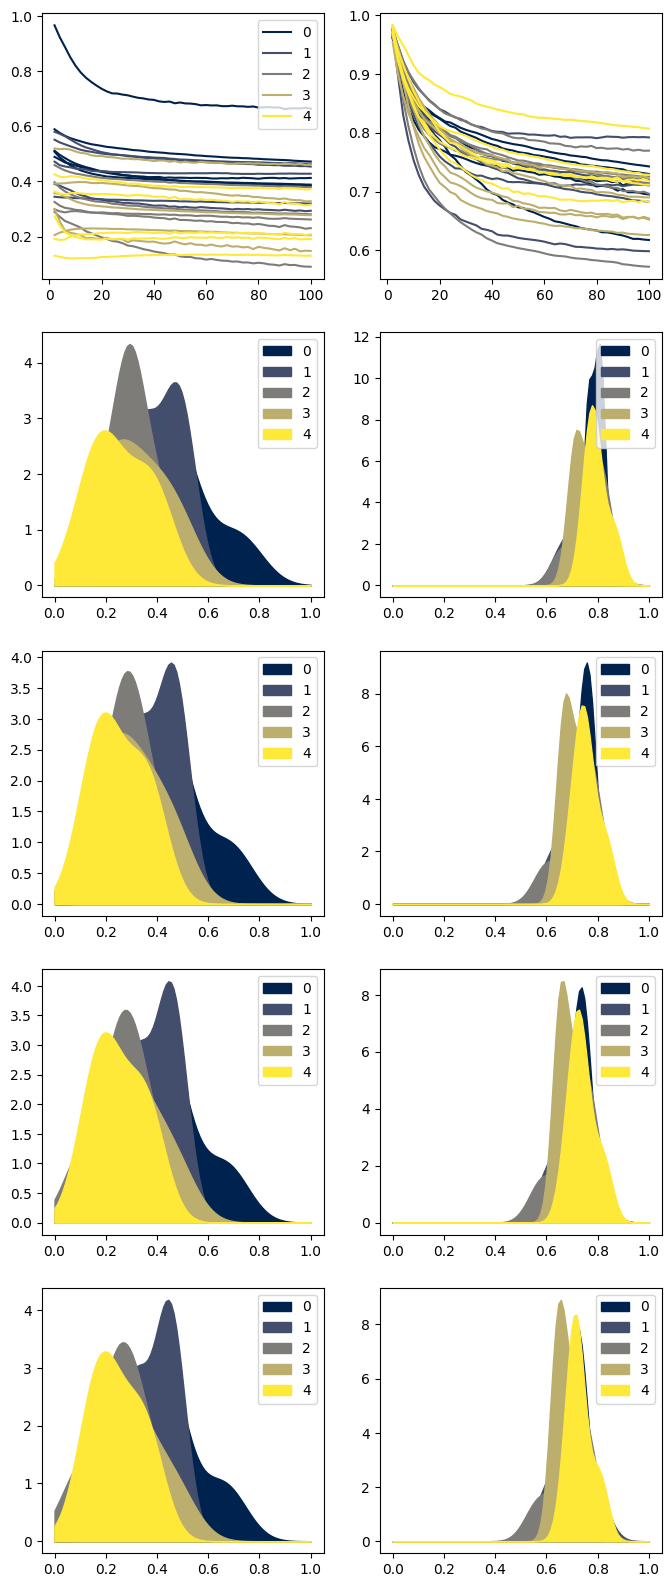

In [7]:
N=len(epoch_list)

colors = plt.cm.cividis(np.linspace(0, 1, len(LABELS_TO_INVESTIGATE)))

fig,axs=plt.subplots(len(dots_den_tr)+1,2,figsize=(8,4*(len(dots_den_tr)+1)))

for i in range(len(LABELS_TO_INVESTIGATE)):
    for j in range(S_G):
        if j==0:
            axs[0,0].plot(epoch_list,[dots_tr[n][i*S_G+j] for n in range(N)], c=colors[i],label=str(LABELS_TO_INVESTIGATE[i]))
            axs[0,1].plot(epoch_list,[dots_ts[n][i*S_G+j] for n in range(N)], c=colors[i],label=str(LABELS_TO_INVESTIGATE[i]))
        else:
            axs[0,0].plot(epoch_list,[dots_tr[n][i*S_G+j] for n in range(N)], c=colors[i])
            axs[0,1].plot(epoch_list,[dots_ts[n][i*S_G+j] for n in range(N)], c=colors[i])
axs[0,0].legend()
axs[1,1].legend()

for i,dens in enumerate(dots_den_tr):
    for j,den in enumerate(dens):
        axs[i+1,0].fill_between(den_x_tr[i],den,color=colors[j],label=str(j))
    axs[i+1,0].legend()

for i,dens in enumerate(dots_den_ts):
    for j,den in enumerate(dens):
        axs[i+1,1].fill_between(den_x_ts[i],den,color=colors[j],label=str(j))
    axs[i+1,1].legend()

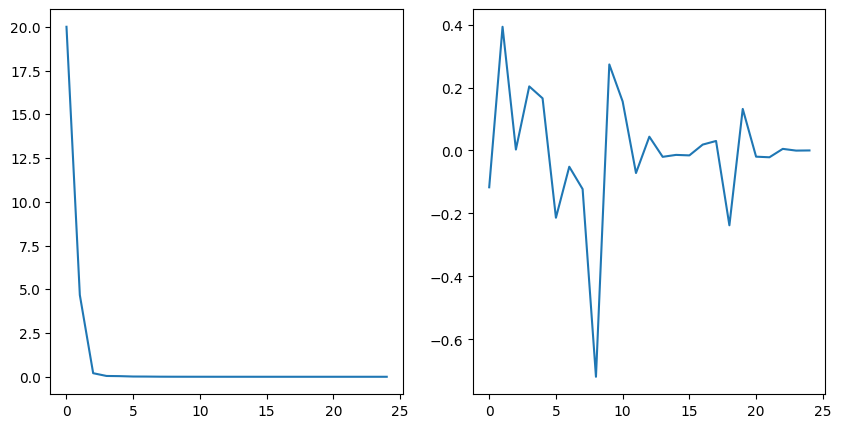

In [8]:
grad_matrix=[]
for image,label in G_loader_ts:
        image = image.reshape(-1, 28*28)
        output=model(image)
        loss = criterion(output,label)
        loss.backward()
        gradient=[]
        gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
        gradient+=model.input_layer.bias.grad.tolist()
        gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
        gradient+=model.output_layer.bias.grad.tolist()
        gradient=np.array(gradient)
        gradient=gradient/np.linalg.norm(gradient)
        grad_matrix.append(gradient)

ker_matrix=[]
for vec1 in grad_matrix:
    row=[]
    for vec2 in grad_matrix:
          row.append(np.dot(vec1,vec2))
    ker_matrix.append(row)

evals,evectors=np.linalg.eig(ker_matrix)

fig,axs=plt.subplots(1,2,figsize=(10,5))

axs[0].plot(np.arange(len(evals)),evals)

axs[1].plot(np.arange(len(evectors[0])),evectors[0])

In [9]:
S_G=20
labels_to_investigate=[0,1]
learning_rate=0.1

In [10]:
import copy

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_tr=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_tr.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

labels_tofill=labels_to_investigate.copy()
labels_freq=[0 for k in range(len(labels_tofill))]
G_ind_ts=[]
for k,(image, label) in enumerate(train_loader_1):
    label=label.tolist()[0]
    if label in labels_tofill:
        ix=labels_to_investigate.index(label)
        G_ind_ts.append(k)
        labels_freq[ix]+=1
        if labels_freq[ix]==S_G:
            labels_tofill.remove(label)
    if len(labels_tofill)==0:
        break

G_subset_tr=Subset(train_dataset, G_ind_tr)
G_subset_ts=Subset(test_dataset, G_ind_ts)

G_loader_tr = DataLoader(dataset=G_subset_tr, batch_size=1, shuffle=False)
G_loader_ts = DataLoader(dataset=G_subset_ts, batch_size=1, shuffle=False)

In [11]:
model = NeuralNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
ReLU_glorot_init(model)


criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)


def train_epoch():
    for images, labels in train_loader:
        images = images.reshape(-1, 28*28)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()
    
epoch_list=[]

for epoch in range(NUM_EPOCHS):
    trainloss=train_epoch()
    print('Epoch: {} TrainLoss: {:.3f}'.format(epoch+1,trainloss))

X=[]
for image,label in G_loader_tr:
    image = image.reshape(-1, 28*28)
    output=model(image)
    loss = criterion(output,label)
    loss.backward()
    gradient=[]
    gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
    gradient+=model.input_layer.bias.grad.tolist()
    gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
    gradient+=model.output_layer.bias.grad.tolist()
    gradient=np.array(gradient)
    gradient=gradient/np.linalg.norm(gradient)
    X.append(gradient)

Epoch: 1 TrainLoss: 0.939
Epoch: 2 TrainLoss: 0.539
Epoch: 3 TrainLoss: 0.437
Epoch: 4 TrainLoss: 0.465
Epoch: 5 TrainLoss: 0.412
Epoch: 6 TrainLoss: 0.352
Epoch: 7 TrainLoss: 0.382
Epoch: 8 TrainLoss: 0.410
Epoch: 9 TrainLoss: 0.245
Epoch: 10 TrainLoss: 0.223
Epoch: 11 TrainLoss: 0.175
Epoch: 12 TrainLoss: 0.161
Epoch: 13 TrainLoss: 0.273
Epoch: 14 TrainLoss: 0.212
Epoch: 15 TrainLoss: 0.243
Epoch: 16 TrainLoss: 0.305
Epoch: 17 TrainLoss: 0.235
Epoch: 18 TrainLoss: 0.093
Epoch: 19 TrainLoss: 0.157
Epoch: 20 TrainLoss: 0.151
Epoch: 21 TrainLoss: 0.135
Epoch: 22 TrainLoss: 0.124
Epoch: 23 TrainLoss: 0.160
Epoch: 24 TrainLoss: 0.137
Epoch: 25 TrainLoss: 0.153
Epoch: 26 TrainLoss: 0.114
Epoch: 27 TrainLoss: 0.109
Epoch: 28 TrainLoss: 0.118
Epoch: 29 TrainLoss: 0.109
Epoch: 30 TrainLoss: 0.145
Epoch: 31 TrainLoss: 0.077
Epoch: 32 TrainLoss: 0.099
Epoch: 33 TrainLoss: 0.050
Epoch: 34 TrainLoss: 0.058
Epoch: 35 TrainLoss: 0.052
Epoch: 36 TrainLoss: 0.080
Epoch: 37 TrainLoss: 0.097
Epoch: 38 

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

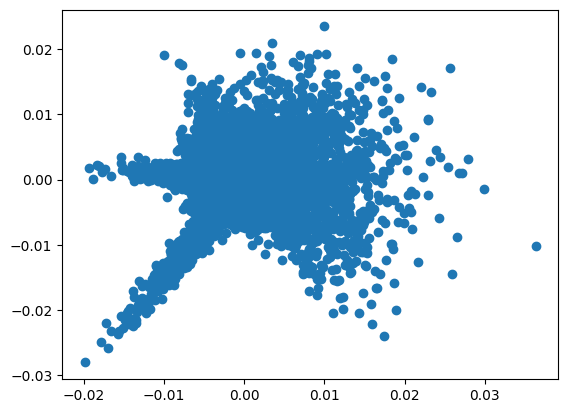

In [13]:
plt.scatter(pca.components_[0],pca.components_[1])